# 리뷰 기반 게임 검색

In [1]:
import os
import time
import pickle
import joblib
import sys

import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer #CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import nltk

from nltk.corpus import stopwords
from collections import Counter

# 추가한 라이브러리
import re
import joblib

import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

from tqdm import tqdm

In [2]:
# read Dataset of 크롤링

game_df = joblib.load('preprocessing/game_pkl/best_games_150.pkl')

In [3]:
game_df.head()

,platform,title,publisher,static,detail,0,1,2,3,4,...,90,91,92,93,94,95,96,97,98,99
0,DS,Ghost Trick: Phantom Detective,Capcom,"{'user': {'positive': 1552, 'mixed': 12, 'nega...",{'summary': 'Ghost Trick is a story of mystery...,"{'score': 10, 'review': 'Easily one of the bes...","{'score': 9, 'review': 'Hands down, one of the...","{'score': 10, 'review': 'Innovative and addict...","{'score': 10, 'review': 'Phenomenal. This game...","{'score': 10, 'review': 'I picked up this game...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PSP,Z.H.P. Unlosing Ranger vs Darkdeath Evilman,NIS America,"{'user': {'positive': 1038, 'mixed': 3, 'negat...",{'summary': 'Known as ZettaiHero Keikakuin Jap...,"{'score': 8, 'review': 'Probably the best rogu...","{'score': 8, 'review': 'If you aren't familiar...","{'score': 10, 'review': 'NIS has always writte...","{'score': 9, 'review': 'It is really amazing t...","{'score': 10, 'review': 'Truly a unique experi...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DS,Metal Torrent,Nintendo,"{'user': {'positive': 1338, 'mixed': 0, 'negat...",{'summary': '[DSiWare] Prepare for a high lev...,"{'score': 10, 'review': 'A rather brilliant lo...","{'score': 1, 'review': 'Boring shoter.. not tu...","{'score': 0, 'review': 'Just to this game not ...","{'score': 0, 'review': 'Ut see him from Robert...","{'score': 0, 'review': 'Mediocre thrash metal ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Xbox One,Superliminal,Pillow Castle Games,"{'user': {'positive': 1733, 'mixed': 12, 'nega...",{'summary': ' Perception is reality. In this m...,"{'score': 7, 'review': 'Superliminal is a stim...","{'score': 6, 'review': 'Superliminal is a sati...","{'score': 10, 'review': 'What a masterpiece. L...","{'score': 9, 'review': 'Really fun gameS fun p...","{'score': 10, 'review': 'This game is unlike a...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Switch,Superliminal,Pillow Castle Games,"{'user': {'positive': 1222, 'mixed': 16, 'nega...",{'summary': 'Perception is reality. Escape fro...,"{'score': 10, 'review': 'Fitting in neatly wit...","{'score': 7, 'review': 'It certainly fits in t...","{'score': 6, 'review': 'Really unique (from an...","{'score': 4, 'review': 'I read that this game ...","{'score': 7, 'review': 'Superliminal is a smar...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
game_df[(game_df['platform'].astype(str) == 'PC') == True]

,platform,title,publisher,static,detail,0,1,2,3,4,...,90,91,92,93,94,95,96,97,98,99
11,PC,Final Fantasy XIV: Endwalker,Square Enix,"{'user': {'positive': 1342, 'mixed': 31, 'nega...",{'summary': 'Endwalker is the fourth expansion...,"{'score': 10, 'review': 'Endwalker solidifies ...","{'score': 10, 'review': 'Square Enix somehow f...","{'score': 10, 'review': 'The best story, full ...","{'score': 10, 'review': 'Issa masterpiece. For...","{'score': 10, 'review': 'It seemed impossible,...",...,"{'score': 10, 'review': 'The queue are long, b...","{'score': 10, 'review': 'A great finale to the...","{'score': 10, 'review': 'This is the best expa...","{'score': 10, 'review': 'This game, this game ...","{'score': 10, 'review': 'Moving scenes, nice a...","{'score': 10, 'review': 'I like the story of t...","{'score': 10, 'review': 'They did what many of...","{'score': 10, 'review': 'For me, Endwalker is ...","{'score': 10, 'review': 'I... was afraid when ...","{'score': 10, 'review': 'One of the best JRPG/..."
18,PC,GhostWire: Tokyo,Bethesda Softworks,"{'user': {'positive': 699, 'mixed': 49, 'negat...",{'summary': 'Save a Tokyo under siege by spiri...,"{'score': 9, 'review': 'Nothing extremely spec...","{'score': 10, 'review': 'Beautiful and fun gam...","{'score': 10, 'review': 'Overall good game, no...","{'score': 10, 'review': 'If anyone was expecti...","{'score': 5, 'review': 'A very interesting and...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,PC,Half-Life: Alyx,Valve Software,"{'user': {'positive': 2494, 'mixed': 56, 'nega...",{'summary': 'Half-Life: Alyx is Valve's VR ret...,"{'score': 10, 'review': 'This is the beginning...","{'score': 10, 'review': 'It's not just another...","{'score': 10, 'review': 'It's a masterpiece. I...","{'score': 10, 'review': 'The revolution has be...","{'score': 10, 'review': 'Fantastic game! Very ...",...,"{'score': 10, 'review': 'This is from far the ...","{'score': 10, 'review': 'Best game ever i m ju...","{'score': 10, 'review': 'Next level Experience...","{'score': 10, 'review': 'Score is 10, The qual...","{'score': 10, 'review': 'crown and it was disg...","{'score': 10, 'review': 'The closest thing to ...","{'score': 10, 'review': 'Valve 1998: ""this is ...","{'score': 10, 'review': 'Ignore the 0's from a...","{'score': 10, 'review': 'Valve somehow could r...","{'score': 10, 'review': 'GREAT GAME!!! This ga..."
22,PC,Final Fantasy XIV: Shadowbringers,Square Enix,"{'user': {'positive': 1209, 'mixed': 26, 'nega...",{'summary': 'Take part in the next saga of FIN...,"{'score': 10, 'review': 'Honestly I've played ...","{'score': 10, 'review': 'Shadowbringers is, in...","{'score': 10, 'review': 'Amazing story. Graphi...","{'score': 10, 'review': 'Hello, I'm absolutly ...","{'score': 10, 'review': 'The story continues a...",...,"{'score': 10, 'review': 'One of the best stori...","{'score': 10, 'review': 'The best Final Fantas...","{'score': 10, 'review': 'Simply the best expan...","{'score': 10, 'review': 'I made an account jus...","{'score': 10, 'review': 'Absolutely the best E...","{'score': 10, 'review': 'Too good for an mmo.T...","{'score': 10, 'review': 'I'm a lazy person and...","{'score': 10, 'review': 'This Expansion is bey...","{'score': 10, 'review': 'The best expansion of...","{'score': 10, 'review': 'Best mmorpg best DLC ..."
24,PC,Vanquish,Sega,"{'user': {'positive': 596, 'mixed': 56, 'negat...","{'summary': 'Directed by Shinji Mikami, VANQUI...","{'score': 10, 'review': 'What a AWESOME game t...","{'score': 10, 'review': 'Vanquish is another P...","{'score': 8, 'review': 'Even though it took th...","{'score': 6, 'review': 'I loved the game. it w...","{'score': 9, 'review': 'There isn't much game-...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,PC,Diaries of a Spaceport Janitor,tinyBuild,"{'user': {'positive': 2967, 'mixed': 6, 'negat...",{'summary': 'Diaries of a Spaceport Janitor is...,"{'score': 9, 'review': 'This game is beautiful...","{'score': 10, 'review': 'Quite possibly the

In [5]:
print('''리뷰 유사도 분석을 통한 머신러닝 모델입니다.\n
평소 즐겨 하는 platform 을 선택하세요
PC      : 0
Console : 1

'''
     )

while True:
    
    platform = int(input())
    if platform in [0, 1]:
        platform = platform == 1
        print(f'{"Console game" if platform else "PC game"}을 선택하셨습니다.\n게임 목록입니다.')
        print(game_df[(game_df['platform'].astype(str) == 'PC') != platform]['title'])
        
        break
        
    else:
        print('올바르게 입력하세요')

리뷰 유사도 분석을 통한 머신러닝 모델입니다.

평소 즐겨 하는 platform 을 선택하세요
PC      : 0
Console : 1


0
PC game을 선택하셨습니다.
게임 목록입니다.
11                          Final Fantasy XIV: Endwalker
18                                      GhostWire: Tokyo
21                                       Half-Life: Alyx
22                     Final Fantasy XIV: Shadowbringers
24                                              Vanquish
25                        Diaries of a Spaceport Janitor
30                              Half-Life 2: Episode Two
31                                                Portal
34                                           Half-Life 2
35                       Warcraft III: The Frozen Throne
36                                                 Mafia
37                          Warcraft III: Reign of Chaos
38                                        Counter-Strike
39                                               Deus Ex
40                                   Planescape: Torment
41                                  

In [6]:
#불용어 사전
stop_words = stopwords.words("english")

# ※정규식 필터링 추가

review_word_pattern = re.compile(r'[A-Za-z]+')

# lemmertizer 생성

lemmatizer = nltk.wordnet.WordNetLemmatizer()

In [7]:
#모든 리뷰 꺼내며 불용어 처리

b_games_review = []

for k in tqdm(range(len(game_df))): 
    
    game_review = ''
    
    for i in range(100):
    
        try:
            game_review += game_df.at[k, i]['review']
            
        except:
            pass
    
    #문장 tokenize, pos tagg, lemmertize
    tags = nltk.pos_tag([word if len(word) > 2 else '' for word in re.findall(review_word_pattern, game_review)])
    
    word_list = []
    
    for word, tag in tags:
        
        if word.lower() not in stop_words:
            
            if tag.startswith('N') or tag.startswith('V') or tag.startswith('R'):
                word_list.append(lemmatizer.lemmatize(word.lower(), tag[0].lower()))
                
            elif tag.startswith('J'):
                word_list.append(lemmatizer.lemmatize(word.lower(), 'a'))
                
            elif tag.startswith('F') or tag.startswith('U'):
                word_list.append(word.lower())
    
    # 문장 재봉합
    game_review = ' '.join(word_list)
            
    b_games_review.append(game_review)

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [01:19<00:00,  1.88it/s]


In [8]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(b_games_review)

In [9]:
# pd.DataFrame(cosine_similarity(X))

In [10]:
# 유사도가 일정치를 넘는 결과 보기

# cos_array = cosine_similarity(X)
# threshold = 0.6

# for i in range(50):
#     for j in range(i+1, 50):
#         if cos_array[i][j] > threshold:
#             print(game_df.at[i, 'title'], game_df.at[i, 'platform'], '||',game_df.at[j, 'title'], game_df.at[j, 'platform'])

In [11]:
#게임정보 출력 함수화
def game_info(game_index):
    
    img = Image.open("preprocessing/GameImage2/"+str(game_index)+".png") # 기존 게임 이미지 파일들을 GameImage2 로 이동
    display(img)
    wimg = Image.open("visualizing/WordCloud/BestReview/b"+str(game_index)+".png") # Wordcloud
    display(wimg)
    img.close()
    wimg.close()
    
    print('\n게임의 정보입니다.\n\n'+ game_df['title'][game_index]+ '\n' +
      
    '******************************\n'
    'Platform : ' + game_df['platform'][game_index] + '\n'
    'user   Score ' + str(int(game_df['static'][game_index]['user']['mean']) * 10) + '/100\n'
    'static Score ' + str(game_df['static'][game_index]['critic']['mean'])+ '/100\n'
    '**********게임설명*************\n' + game_df['detail'][game_index]['summary']
    )

해보고 싶은 Game의 번호를 선택하세요
92


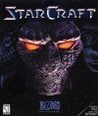

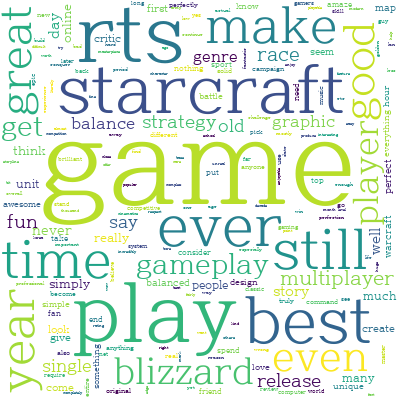


게임의 정보입니다.

Starcraft
******************************
Platform : PC
user   Score 90/100
static Score 88/100
**********게임설명*************
In the distant future a small group of human exiles have been doomed to fight for survival on the edge of the galaxy. Through military strength, espionage and deceit, a unified Terran government has maintained an uneasy peace. As resources run short, however, these Confederate nations find themselves looking towards the rich worlds of their alien neighbors, the enigmatic Protoss. To further complicate matters, it seems that a previously unknown and deadly species known only as the Zerg has entered Protoss space and is destroying everything in its path. The time for war has come... As the military leader for your species, you must gather the resources you need to train and expand your forces and lead them to victory. 30 unique missions will challenge you across three different campaigns as you control the fate of the galaxy.
None


In [12]:
print('해보고 싶은 Game의 번호를 선택하세요')

game_index = -1

while True:
    
    game_index = int(input())
    
    if game_index in game_df[(game_df['platform'] != 'PC') == platform]['title'].index:
        break
    else:
        print('없는 Game의 번호입니다. 다시 입력해주세요')
        
print(game_info(game_index))

********************리뷰기반 추천게임********************

리뷰가 가장 비슷한 상위 3가지 게임 입니다.




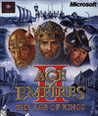

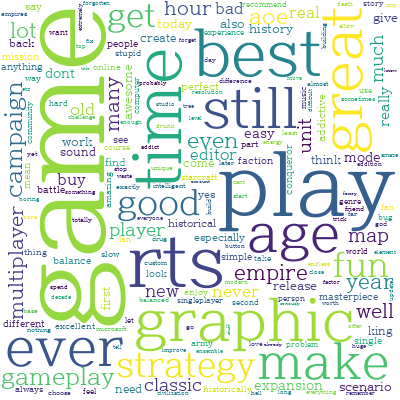


게임의 정보입니다.

Age of Empires II: The Age of Kings
******************************
Platform : PC
user   Score 90/100
static Score 92/100
**********게임설명*************
Age of Empires II: The Age of Kings is the sequel to the award-winning, best-selling real-time strategy game "Age of Empires." Age of Empires II spans a thousand years, from the fall of Rome through the Middle Ages in which players lead one of 13 civilizations into greatness. The game keeps the epic scope of Age of Empires' game play while evolving the combat and economic features. [Microsoft]
None


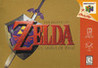

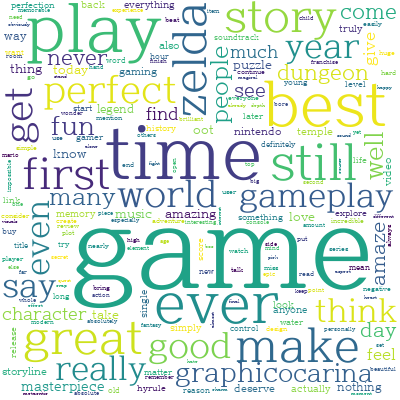


게임의 정보입니다.

The Legend of Zelda: Ocarina of Time
******************************
Platform : Nintendo 64
user   Score 90/100
static Score 99/100
**********게임설명*************
As a young boy, Link is tricked by Ganondorf, the King of the Gerudo Thieves. The evil human uses Link to gain access to the Sacred Realm, where he places his tainted hands on Triforce and transforms the beautiful Hyrulean landscape into a barren wasteland. Link is determined to fix the problems he helped to create, so with the help of Rauru he travels through time gathering the powers of the Seven Sages.
None


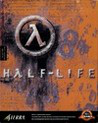

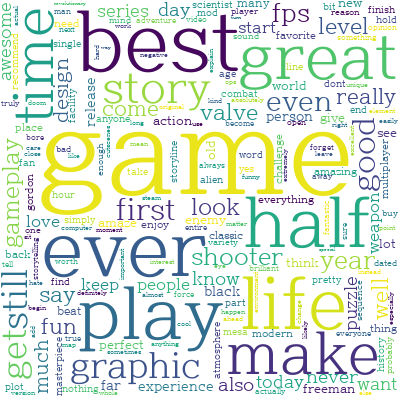


게임의 정보입니다.

Half-Life
******************************
Platform : PC
user   Score 90/100
static Score 96/100
**********게임설명*************
Half-Life combines great storytelling in the tradition of Stephen King with intense action and advanced technology to create a frighteningly realistic world where players need to think smart to survive. Half-Life has won more than 50 Game of the Year awards from publications around the world, and was named 'Best PC Game Ever' in PC Gamer's November 1999 issue. [Sierra]
None


In [13]:
print('''********************리뷰기반 추천게임********************

리뷰가 가장 비슷한 상위 3가지 게임 입니다.

''')

result_list = []

cos_sim_df = pd.DataFrame(cosine_similarity(X))[game_index].copy()

for k in cos_sim_df.sort_values(ascending=False).index:
    
    if game_df.at[k, 'title'] != game_df.at[game_index, 'title'] and game_df.at[k, 'publisher'] != game_df.at[game_index, 'publisher']:
        
        result_list.append(k)
        
    if len(result_list) == 3:
        
        break

for idx in result_list:
    
    print(game_info(idx))
